In [60]:
import pandas as pd 
import numpy as np
import random
from statistics import stdev

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from sklearn import model_selection

from scipy import stats
from kmodes.kmodes import KModes
from nltk.stem import SnowballStemmer 

## Functions

In [39]:

stemmer = SnowballStemmer('english')

def replace(t): #Function for catching what the stemmer misses to further reduce the number of categories (so far only for optimized for base notes) 

    if "amber" in t:
        t = "amber"
    if "cash" in t:
        t = "cashmere"
    if "bean" in t:
        t = "bean"
    if "flo" in t:
        t = "floral"
    if "ced" in t:
        t = "cedar"
    if "mu" in t:
        t = "musk"
    if "leather" in t:
        t = "leather"
    if "lil" in t:
        t = "lily"
    if "lacton" in t:
        t = "lacton"
    if "labda" in t:
        t = "labdanum"
    if "patch" in t:
        t = "patchouli"
    if "vanil" in t:
        t = "vanilla"
    if "oud" in t:
        t = "oud"
    if "oliv" in t:
        t = "olive"
    if "sand" in t:
        t = "sandalwood"
    if "wood" in t[:4]:
        t = "wood"
    return t
            
def roundd(scoredict, n):
    for k, v in scoredict.items():
        scoredict[k] = round(v,n)
    return scoredict

def visualize_distribution(df, names, ax):
    mens_total = np.count_nonzero(df['gender'] == 0)
    womens_total = np.count_nonzero(df['gender'] == 1)
  
    counts = np.zeros(shape=(len(names),2))
    for i, feat in enumerate(names):
        men = np.count_nonzero(np.logical_and(df['gender'] == 0, df[feat] == 1))
        women = np.count_nonzero(np.logical_and(df['gender'] == 1, df[feat] == 1))

        counts[i,0] = men/mens_total
        counts[i,1] =  women/womens_total

    counts *= 100

    bar_labels = np.empty((6,2), dtype = 'object')
    for i in range(len(counts)):
        for j in range(2):
            bar_labels[i,j] = names[i] + ", {:.1f}".format(counts[i,j]) + "%"

    bar_labels[5,0] = "Other, {:.1f}".format(100-sum(counts[:,0])) + "%"
    bar_labels[5,1] = "Other, {:.1f}".format(100-sum(counts[:,1])) + "%"
    
    labels = ["Men", "Women"]
    width = 0.5   
    bars = []
 
    bars.append(ax.bar(labels, counts[0], width))
    for i in range(1,len(counts)):
 
        bars.append(ax.bar(labels, counts[i], width, bottom=sum(counts[:i])))

    bars.append(ax.bar(labels, 100-sum(counts), width, bottom=sum(counts)))
    ax.set_title('Distribution of scents per department')


    for i, bar in enumerate(bars[:5]):
        plt.bar_label(bar, labels = bar_labels[i], label_type ='center')

    plt.bar_label(bars[5], labels = bar_labels[5], label_type = 'center')

    plt.show()

class ReplaceCountVectorizer(CountVectorizer):
    
     def build_analyzer(self):
        analyzer = super(ReplaceCountVectorizer, self).build_analyzer()
        return lambda doc: ([replace(w) for w in analyzer(doc)])
    
class StemmedCountVectorizer(CountVectorizer): #Builds ontop of sklearn:s CountVectorizer, documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    
     def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(replace(w)) for w in analyzer(doc)]) 

In [3]:
scaler = StandardScaler()
mlb = LabelEncoder()
plt.style.use('seaborn')

df_original = pd.read_csv("data/noon_perfumes_dataset.csv", index_col=0)

df = df_original.copy(deep=True)
df.drop_duplicates(inplace=True)

### Pre-processing

In [4]:
#CONVERT PRICE TO REAL MONEYS
df.old_price = df_original.old_price*0.24
df.new_price = df_original.new_price*0.24

#Create price/ML because sizes range from sample size to large bottles
df['price_ml'] = df['new_price'] / df['ml']
low, high = np.quantile(df['price_ml'],[0.25, 0.75])
df['price'] = np.select([df.price_ml < low, df.price_ml > high], ["cheap", "expensive"], default=["medium"])

In [5]:
#REMOVE THE CHILD AND BINARIZE GENDERS
df.drop(index=df[df.department == 'Kids Unisex'].index, inplace=True)
df.drop(index=df[df.department == 'Unisex'].index, inplace=True)

In [6]:
#REMOVE THE OIL
df.drop(index=df[df.concentration == 'Oil'].index, inplace=True)
df.drop(index=df[df.concentration == 'EDC'].index, inplace=True)

In [7]:
#REMOVE THE PDT
df.drop(index=df[df.concentration == 'PDT'].index, inplace=True)

In [8]:
#REMOVE OUTLIERS
low_rating, high_rating = df.item_rating.quantile(0.01), df.item_rating.quantile(0.99)
low_priceML, high_priceML = df.price_ml.quantile(0.01), df.price_ml.quantile(0.99)

df = df[(df.item_rating >= low_rating) & (df.item_rating <= high_rating)]
df = df[(df.price_ml >= low_priceML) & (df.price_ml <= high_priceML)]

In [9]:
gender = df.department.apply(lambda y: 1 if y == 'Women' else -1)

notes = df[['base_note', 'middle_note']].values
base_note = df['base_note'].values
middle_note = df['middle_note'].values

scents = df['scents'].values
cat_df = df[['brand', 'concentration','scents','price']]

## Kmodes


In [10]:
pricelist = []

for i in range(2,8):
    kmode = KModes(n_clusters=i, init = "random", n_init = 20, random_state=13424)
    kmode.fit(cat_df)
    pricelist.append([i, min(kmode.epoch_costs_)])

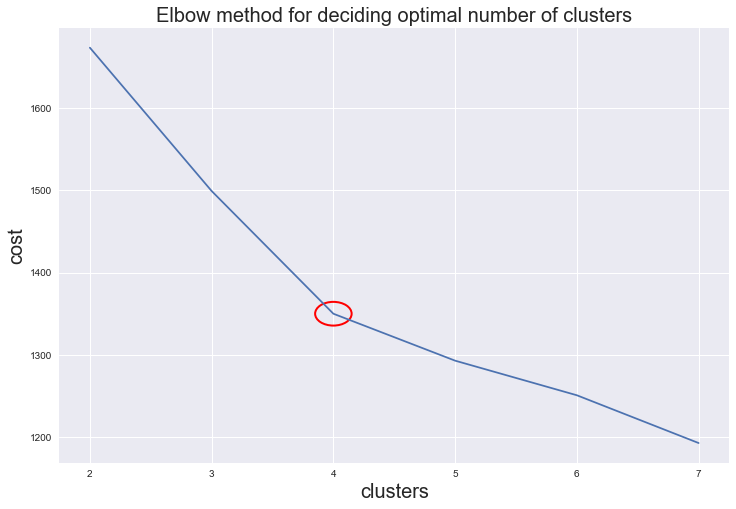

In [11]:
from matplotlib.patches import Ellipse
prices = np.array(pricelist)

fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(prices[:,0], prices[:,1])

scale = np.abs(ax.get_ylim()[0]-ax.get_ylim()[-1])/np.abs(ax.get_xlim()[0]-ax.get_xlim()[-1])
size = 0.3
elbow = Ellipse((prices[2]), size,size*scale, fill=False, color='r', linewidth=2)
plt.ylabel("cost", size=20)
plt.xlabel("clusters", size=20)
plt.title("Elbow method for deciding optimal number of clusters", size=20)
ax.add_patch(elbow)
plt.show()

In [12]:
kmode = KModes(n_clusters=4, max_iter=500, init = "random", 
               n_init = 60, random_state=231)
preds = kmode.fit_predict(cat_df)
print(kmode.cluster_centroids_)

[['GUCCI' 'EDP' 'Floral' 'expensive']
 ['BURBERRY' 'EDP' 'Floral' 'medium']
 ['DORALL COLLECTION' 'EDT' 'Woody' 'cheap']
 ['HUGO BOSS' 'EDT' 'Woody' 'medium']]


In [40]:
df_corr = df.copy(deep=True)
df_corr.drop(['old_price','new_price','ml','seller_rating','brand','name','department', 'scents', 'base_note', 'middle_note', 'seller','num_seller_ratings','price'], axis=1, inplace=True)
df_corr['gender'] = gender
df_corr['concentration'] = df.concentration.apply(lambda y: 1 if y == 'EDP' else -1)
df_corr[['item_rating', 'price_ml']] = scaler.fit_transform(df_corr[['item_rating','price_ml']])
df_corr['clusters'] = preds

In [14]:
l = 0
df_corr = df_corr[['concentration','gender','item_rating','price_ml','clusters']]
for i in range(len(kmode.cluster_centroids_)):
    
    subset = (df_corr.clusters == i)
    if not l:
        means = df_corr[subset].mean()[:-1]
        l = 1
    else:
        means = np.vstack((means, df_corr[subset].mean()[:-1]))

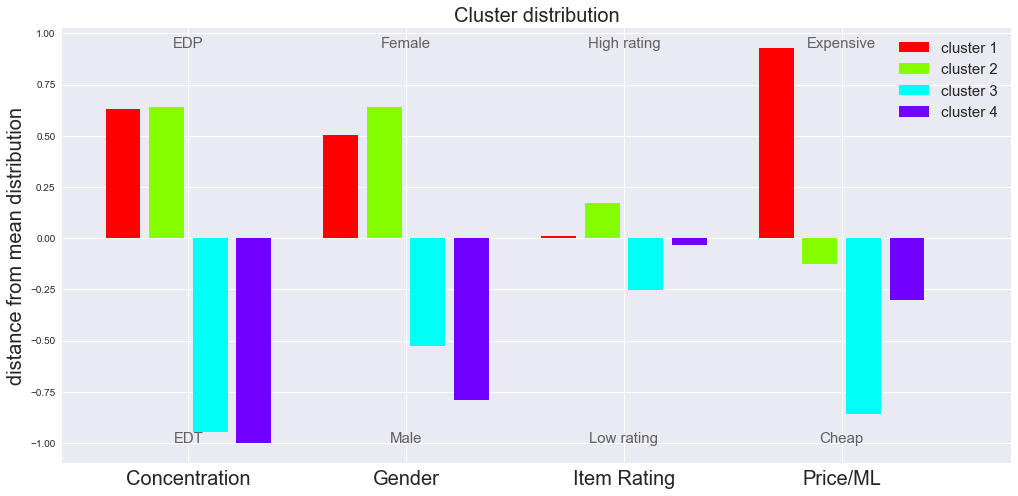

In [15]:
means_spaced = np.hstack((means.T, np.zeros((means.T.shape[0],1)))).flatten()

cmap = cm.hsv
colors = np.resize(np.arange(len(kmode.cluster_centroids_)+1), (means.T.shape[0]+1)*means.T.shape[1])
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(17,8))
plot = plt.bar(range(len(means_spaced)), means_spaced, color=m.to_rgba(colors))

tick_spacing = np.linspace(0, len(means_spaced), len(means.T)+1)[:-1]+1.5
plt.ylabel("distance from mean distribution", fontsize=20)

plt.xticks(ticks = tick_spacing, labels=['Concentration', 'Gender', 'Item Rating', 'Price/ML'], fontsize=20)
plt.legend(handles=plot[:4],labels=["cluster {}".format(i+1) for i in range(kmode.get_params()['n_clusters'])], fontsize=15)
plt.text(1.5, -1, "EDT", ha='center', fontsize=15, alpha=0.7)
plt.text(1.5, 0.93, "EDP", ha='center', fontsize=15, alpha=0.7)
plt.text(6.5,0.93, "Female", ha='center', fontsize=15, alpha=0.7)
plt.text(6.5,-1, "Male", ha='center', fontsize=15, alpha=0.7)
plt.text(11.5,0.93, "High rating", ha='center', fontsize=15, alpha=0.7)
plt.text(11.5,-1, "Low rating", ha='center', fontsize=15, alpha=0.7)
plt.text(16.5,0.93, "Expensive", ha='center', fontsize=15, alpha=0.7)
plt.text(16.5,-1, "Cheap", ha='center', fontsize=15, alpha=0.7)
plt.title("Cluster distribution", size=20);

### PLOTTING

In [17]:
vect_base = ReplaceCountVectorizer(max_features = 60, stop_words = ['accord','black','dry','white', 'accords', 'note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])
X1 = vect_base.fit_transform(base_note)

base_names = vect_base.get_feature_names()
base_df = pd.DataFrame(X1.todense(), columns = base_names)
base_df['gender'] = mlb.fit_transform(gender)
base_df[base_df.columns] = scaler.fit_transform(base_df[base_df.columns.values])

mean_prices = []
modes = []

for note in base_names:
    mean = df.price_ml[df['base_note'].str.contains(note, case=False)].mean()
    mode = stats.mode(preds[df['base_note'].str.contains(note, case=False)], nan_policy='omit')[0]
    modes.append(mode)
    mean_prices.append(mean)

/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


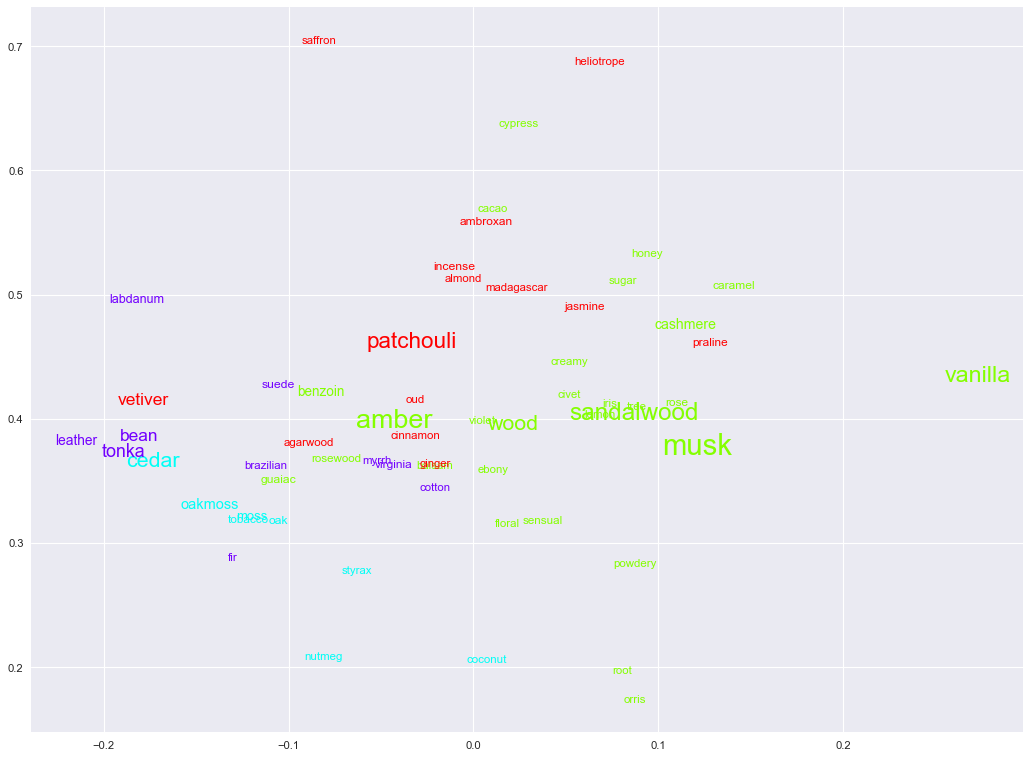

In [18]:
norm = mpl.colors.Normalize(vmin=min(modes)[0], vmax=max(modes)[0]+1)
cmap = cm.hsv
m = cm.ScalarMappable(norm=norm, cmap=cmap)

X = base_df.corr().iloc[-1][:-1] # Correlation between base notes and gender M/F
Y = mean_prices # Mean price for each
Z = sum(X1.toarray())
plt.figure(figsize=(16, 12), dpi=80)
plt.scatter(X,Y, s =0, c=modes)
for i, d in enumerate(zip(X,Y)):
    plt.annotate(base_names[i], d, ha='center',color=m.to_rgba(int(modes[i])), va='center',fontsize = Z[i]/23 + 10); # Fontsize needs to be scaled, I thought this was optimal to keep everything readable

## Supervised Learning

In [26]:
vect_base = StemmedCountVectorizer(stop_words = ['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])
vect_middle = StemmedCountVectorizer(stop_words = ['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])
vect_scents = StemmedCountVectorizer(stop_words = ['and'])

X1 = vect_base.fit_transform(base_note) #Binarized feature vector for base notes (<insert shape after preprocessing>)
X2 = vect_middle.fit_transform(middle_note) #Same for middle notes (<insert shape after preprocessing>)
X3 = vect_scents.fit_transform(scents) #Same for scents (<insert shape after preprocessing>)

random.state = 43

X_comb = np.hstack((X1.toarray(), X2.toarray(), X3.toarray())) #Combined features

nb = BernoulliNB()
mlp = MLPClassifier(max_iter = 500, solver = 'lbfgs')
rf = RandomForestClassifier(n_estimators = 500)
knn = KNeighborsClassifier(metric='jaccard', n_neighbors=1)
svm = SVC()
baseline = DummyClassifier(strategy='most_frequent')

classifiers = {"NB": nb, "MLP": mlp, "RF": rf, "kNN": knn, "SVM": svm, "baseline": baseline}

### Base notes only

In [32]:
base_scores = {}
base_stdevs = {}
for name, clf in classifiers.items():
    if name == "kNN":
        scores = cross_val_score(clf,X1.toarray().astype('bool'), gender, cv=5)
    else:
        scores = cross_val_score(clf,X1.toarray(), gender, cv=5)
    mean = scores.mean()
    std = stdev(scores)
    base_scores[name] = mean
    base_stdevs[name] = std
print(base_scores)

{'NB': 0.7539129133622625, 'MLP': 0.7307421816549454, 'RF': 0.7417327547508604, 'kNN': 0.728288193924884, 'SVM': 0.763751309292234, 'baseline': 0.5324405207242257}


### Middle notes only

In [33]:
mid_scores = {}
mid_stdevs = {}
for name, clf in classifiers.items():
    if name == "kNN":
        scores = cross_val_score(clf,X2.toarray().astype('bool'), gender, cv=5)
    else:
        scores = cross_val_score(clf,X2.toarray(), gender, cv=5)
    mean = scores.mean()
    std = stdev(scores)
    mid_scores[name] = mean
    mid_stdevs[name] = std
print(mid_scores)

{'NB': 0.8726694598234325, 'MLP': 0.8567634295974862, 'RF': 0.8739039353583721, 'kNN': 0.843341313781236, 'SVM': 0.8849094717941044, 'baseline': 0.5324405207242257}


### Scents only

In [34]:
scent_scores = {}
scent_stdevs = {}
for name, clf in classifiers.items():
    if name == "kNN":
        scores = cross_val_score(clf,X3.toarray().astype('bool'), gender, cv=5)
    else:
        scores = cross_val_score(clf,X3.toarray(), gender, cv=5)
    mean = scores.mean()
    std = stdev(scores)
    scent_scores[name] = mean
    scent_stdevs[name] = std
print(scent_scores)

{'NB': 0.7808469250336676, 'MLP': 0.7808394433637589, 'RF': 0.7808469250336676, 'kNN': 0.7343408648810414, 'SVM': 0.7845129432889422, 'baseline': 0.5324405207242257}


### All features

In [35]:
comb_scores = {}
comb_stdevs = {}
for name, clf in classifiers.items():
    if name == "kNN":
        scores = cross_val_score(clf,X_comb.astype('bool'), gender, cv=5)
    else:
        scores = cross_val_score(clf,X_comb, gender, cv=5)
    mean = scores.mean()
    std = stdev(scores)
    comb_scores[name] = mean
    comb_stdevs[name] = std
print(comb_scores)

{'NB': 0.9118434834655096, 'MLP': 0.8849543618135567, 'RF': 0.8996259165045638, 'kNN': 0.8617162950770612, 'SVM': 0.8898099655843185, 'baseline': 0.5324405207242257}


In [37]:
base_scores = roundd(base_scores,2)
mid_scores = roundd(mid_scores,2)
scent_scores = roundd(scent_scores,2)
comb_scores = roundd(comb_scores,2)

rows_list = [base_scores, mid_scores, scent_scores, comb_scores]
res = pd.DataFrame(rows_list)
res[" "] = ["Base Notes", "Middle Notes", "Scents", "Features Combined"]
res = res.set_index([" "])

# res.to_csv("table2.csv") # uncomment to save table

res

,NB,MLP,RF,kNN,SVM,baseline
,,,,,,
Base Notes,0.75,0.73,0.74,0.73,0.76,0.53
Middle Notes,0.87,0.86,0.87,0.84,0.88,0.53
Scents,0.78,0.78,0.78,0.73,0.78,0.53
Features Combined,0.91,0.88,0.90,0.86,0.89,0.53


### SVM Grid Search


In [41]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=1)
grid_comb = grid.fit(X_comb,gender)

grid_scores_comb = cross_val_score(grid_comb, X_comb, gender)
print(grid_scores_comb.mean())

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.891036959449349


In [42]:
grid_comb.best_estimator_

SVC(C=10, gamma=0.01)

In [54]:
conf_matrix_list_of_arrays = []
kf = KFold(n_splits=5)
model = grid_comb.best_estimator_
gender = np.array(gender)
for train_index, test_index in kf.split(X_comb):

   X_train, X_test = X_comb[train_index], X_comb[test_index]
   y_train, y_test = gender[train_index], gender[test_index]

   model.fit(X_train, y_train)
   conf_matrix = confusion_matrix(y_test, model.predict(X_test))
   conf_matrix_list_of_arrays.append(conf_matrix)

In [55]:
mean_conf = np.mean(conf_matrix_list_of_arrays, axis=0)
print(mean_conf)

[[65.8 10.6]
 [ 7.4 79.6]]


## Plotting

In [56]:
# We will include the top 5 features (most frequent) for base notes, middle notes and scents
vect_base = ReplaceCountVectorizer(max_features = 5, stop_words = ['accord', 'accords', 'note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])
vect_middle = ReplaceCountVectorizer(max_features = 5, stop_words = ['of', 'the', 'valley', 'note', 'notes', 'and', 'with', 'ectract', 'co', 'essence', 'masculine'])
vect_scents = ReplaceCountVectorizer(max_features = 5, stop_words = ['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])

X1 = vect_base.fit_transform(base_note)
X2 = vect_middle.fit_transform(middle_note)
X3 = vect_scents.fit_transform(scents)


In [57]:
scent_names = vect_scents.get_feature_names_out()
base_names = vect_base.get_feature_names_out()
middle_names = vect_middle.get_feature_names_out()

scent_df = pd.DataFrame(X3.todense(), columns = scent_names)
base_df = pd.DataFrame(X1.todense(), columns = base_names)
middle_df = pd.DataFrame(X2.todense(), columns = middle_names)

mlb = LabelEncoder()

scent_df['gender'] = mlb.fit_transform(gender) #Binarizing gender (for entirely non-political reasons)
base_df['gender'] = scent_df['gender']
middle_df['gender'] = scent_df['gender']

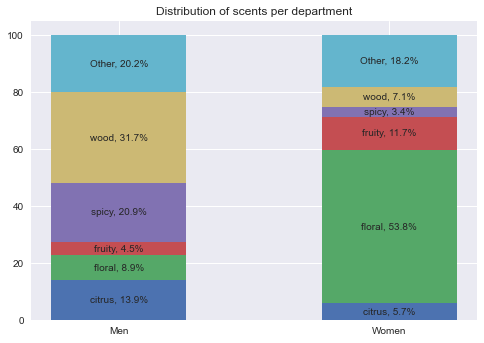

In [58]:
fig, ax = plt.subplots()
visualize_distribution(scent_df, scent_names, ax)


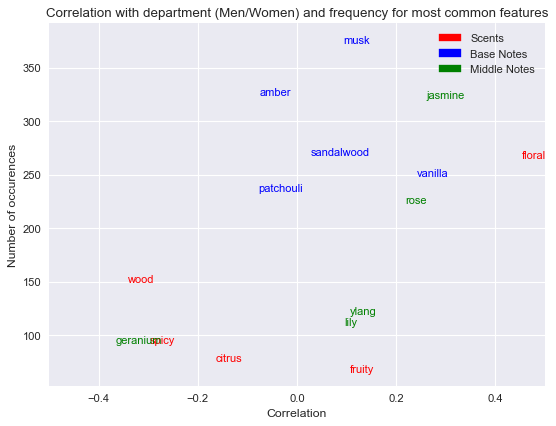

In [62]:
X = scent_df.corr().iloc[-1][:-1] # Correlation between scents and gender M/W
Y = sum(X3.toarray()) #Sum of the columns gives the number of occurences for each scent
plt.style.use('seaborn')
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(X,Y, s =0)
for i, d in enumerate(zip(X,Y)):
    plt.annotate(scent_names[i], d, ha='center', va='center', c='r') 

X = base_df.corr().iloc[-1][:-1] # Correlation between base notes and gender M/W
Y = sum(X1.toarray()) #Sum of the columns gives the number of occurences for each base note
plt.scatter(X,Y, s =0)
for i, d in enumerate(zip(X,Y)):
    plt.annotate(base_names[i], d, ha='center', va='center', c='b')
    
X = middle_df.corr().iloc[-1][:-1] # Correlation between middle notes and gender M/W
Y = sum(X2.toarray()) ##Sum of the columns gives the number of occurences for each middle note
plt.scatter(X,Y, s =0)
for i, d in enumerate(zip(X,Y)):
    plt.annotate(middle_names[i], d, ha='center', va='center', c='g')
    
patch1 = mpatches.Patch(color='r',label='Scents') 
patch2 = mpatches.Patch(color='b', label='Base Notes') 
patch3 = mpatches.Patch(color='g', label='Middle Notes')
plt.legend(framealpha=1, handles=[patch1, patch2, patch3])

plt.xlim(-0.5, 0.5)
plt.title("Correlation with department (Men/Women) and frequency for most common features")
plt.ylabel("Number of occurences")
plt.xlabel("Correlation");
#plt.savefig("Correlation2.png",dpi=300)